In [1]:
using Printf
using Random
Random.seed!(4649373)

using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(500, 350))

ECDF(A, x) = count(≤(x), A) / length(A)

ECDF (generic function with 1 method)

se = √(var(distx) / m + var(disty) / n) = 0.570087712549569
se_shuffle = √(var(disty) / m + var(distx) / n) = 0.31622776601683794
  7.503232 seconds (156.61 M allocations: 4.150 GiB, 7.95% gc time, 60.14% compilation time)
mean(diff) = 0.015361067435398088
std(diff) = 0.5831801016778241
ECDF.((pval, pval2, pval3), 0.1) = (0.3645, 0.36525, 0.107)
ECDF.((pval, pval2, pval3), 0.05) = (0.29175, 0.296, 0.05225)


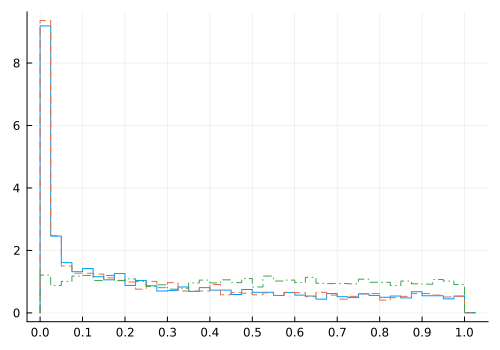

In [2]:
distx = Normal(0, 1)
m = 200
disty = Normal(0, 4)
n = 50
L = 4000
Nshuffles = 4000

@show se = √(var(distx)/m + var(disty)/n)
@show se_shuffle = √(var(disty)/m + var(distx)/n)

nth = Threads.nthreads()
XYtmp = [zeros(m+n) for _ in 1:nth]

pval = zeros(L)
pval2 = zeros(L)
pval3 = zeros(L)
diff = zeros(L)
@time Threads.@threads for i in eachindex(pval)
    tid = Threads.threadid()
    XY = XYtmp[tid]
    X = rand!(distx, @view XY[1:m])
    Y = rand!(disty, @view XY[m+1:m+n])
    diff[i] = mean(X) - mean(Y)
    diff_shuffle = zeros(Nshuffles)
    for j in 1:Nshuffles
        shuffle!(XY)
        diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
    end
    P = 2ECDF(diff_shuffle, diff[i])
    pval[i] = min(1, P, 2-P)
    P2 = 2cdf(Normal(0, se_shuffle), diff[i])
    pval2[i] = min(1, P2, 2-P2)
    P3 = 2cdf(Normal(0, se), diff[i])
    pval3[i] = min(1, P3, 2-P3)
end

@show mean(diff) std(diff)

@show ECDF.((pval, pval2, pval3), 0.10)
@show ECDF.((pval, pval2, pval3), 0.05)
plot()
stephist!(pval; norm=true, label="", bin=0:0.025:1.025)
stephist!(pval2; norm=true, label="", bin=0:0.025:1.025, ls=:dash)
stephist!(pval3; norm=true, label="", bin=0:0.025:1.025, ls=:dashdot)
plot!(xtick=0:0.1:1)

diff = mean(X) - mean(Y) = 0.09902460533455348
se2_true = var(distx) / m + var(disty) / n = 0.325
se2_shuffle = var(distx) / n + var(disty) / m = 0.1
(mean(diff_shuffle), var(diff_shuffle)) = (0.0023808879961961025, 0.10918481570758713)


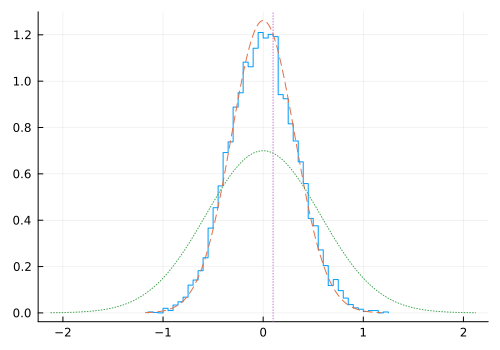

In [3]:
distx, m = Normal(0, 1), 200
disty, n = Normal(0, 4), 50
X = rand(distx, m)
Y = rand(disty, n)
@show diff = mean(X) - mean(Y)
XY = [X; Y]
Nshuffles = 10^4
diff_shuffle = zeros(Nshuffles)
for j in 1:Nshuffles
    shuffle!(XY)
    diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
end
@show se2_true = var(distx)/m + var(disty)/n
@show se2_shuffle = var(distx)/n + var(disty)/m
@show mean(diff_shuffle), var(diff_shuffle)
stephist(diff_shuffle; norm=true, label="")
plot!(Normal(0, √se2_shuffle); label="", ls=:dash)
plot!(Normal(0, √se2_true); label="", ls=:dot)
vline!([diff]; label="", ls=:dot)

In [4]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.01799850645039118, 0.01799850645039118)

In [5]:
function student_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    S2 = ((m-1)*SX2 + (n-1)*SY2) / (m+n-2)
    sehat2 = S2 * (1/m + 1/n)
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = m + n - 2
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_student_t_test(X, Y; μ = 0.0) = student_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_student_t_test(X, Y), pvalue(EqualVarianceTTest(X, Y))

(0.3847930361053551, 0.3847930361053551)

In [6]:
x ⪅ y = x < y || x ≈ y

function pvalue_permutation_test(f, X, Y, XY=[X; Y]; Nshuffles=10^4)
    m, n = length(X), length(Y)
    f_obs = f(X, Y)
    a = b = 0
    for _ in 1:Nshuffles
        shuffle!(XY)
        @views X, Y = XY[1:m], XY[m+1:m+n]
        a += f(X, Y) ⪅ f_obs
        b += f_obs ⪅ f(X, Y)
    end
    min(1, 2a/Nshuffles, 2b/Nshuffles)
end

function pvalue_permutation_diffmean_test(X, Y, XY=[X; Y]; Nshuffles=10^4)
    pvalue_permutation_test(X, Y, XY; Nshuffles) do X, Y
        mean(X) - mean(Y)
    end
end

function pvalue_permutation_student_t_test(X, Y, XY=[X; Y]; Nshuffles=10^4)
    pvalue_permutation_test(X, Y, XY; Nshuffles) do X, Y
        m, n = length(X), length(Y)
        S² = ((m-1)*var(X) + (n-1)*var(Y)) / (m+n-2)
        (mean(X) - mean(Y)) / √(S²*(1/m + 1/n))
    end
end

function pvalue_permutation_welch_t_test(X, Y, XY=[X; Y]; Nshuffles=10^4)
    pvalue_permutation_test(X, Y, XY; Nshuffles) do X, Y
        (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y))
    end
end

function true_pvalue(f, distx, disty, X, Y; randfunc! = rand!, Nsamples=10^4)
    f_obs = f(X, Y)
    Xtmp = similar(X)
    Ytmp = similar(Y)
    a = b = 0
    for _ in 1:Nsamples
        XX = randfunc!(distx, Xtmp)
        YY = randfunc!(disty, Ytmp)
        a += f(XX, YY) ⪅ f_obs
        b += f_obs ⪅ f(XX, YY)
    end
    min(1, 2a/Nsamples, 2b/Nsamples)
end

function true_pvalue_diffmean(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^4)
    true_pvalue(distx, disty, X, Y; randfunc!, Nsamples) do X, Y
        mean(X) - mean(Y)
    end
end

function true_pvalue_student_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^4)
    true_pvalue(distx, disty, X, Y; randfunc!, Nsamples) do X, Y
        m, n = length(X), length(Y)
        S² = ((m-1)*var(X) + (n-1)*var(Y)) / (m+n-2)
        (mean(X) - mean(Y)) / √(S²*(1/m + 1/n))
    end
end

function true_pvalue_welch_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^4)
    true_pvalue(distx, disty, X, Y; randfunc!, Nsamples) do X, Y
        (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y))
    end
end

function pvalue_resampling(X, Y; Nsamples=10^4)
    true_pvalue_diffmean(X, Y, zero(X), zero(Y); randfunc! = sample!, Nsamples)
end

pvalue_resampling (generic function with 1 method)

In [7]:
X = [2, 4, 3, 4, 4, 5]
Y = [1, 7, 8, 9, 7, 8]
@show pvalue_permutation_diffmean_test(X, Y; Nshuffles=10^7)
@show pvalue_permutation_student_t_test(X, Y; Nshuffles=10^7)
@show pvalue_student_t_test(X, Y)
@show pvalue_permutation_welch_t_test(X, Y; Nshuffles=10^7)
@show pvalue_welch_t_test(X, Y)
@show pvalue_resampling(X, Y; Nsamples=10^7)
;

pvalue_permutation_diffmean_test(X, Y; Nshuffles = 10 ^ 7) = 0.058347
pvalue_permutation_student_t_test(X, Y; Nshuffles = 10 ^ 7) = 0.058433
pvalue_student_t_test(X, Y) = 0.03697598534223498
pvalue_permutation_welch_t_test(X, Y; Nshuffles = 10 ^ 7) = 0.0584928
pvalue_welch_t_test(X, Y) = 0.05114850761642216
pvalue_resampling(X, Y; Nsamples = 10 ^ 7) = 0.0223324


In [8]:
X = [2, 4, 3, 4, 4, 2, 3, 3, 4]
Y = [1, 7, 8, 9]
@show pvalue_permutation_diffmean_test(X, Y; Nshuffles=10^6)
@show pvalue_permutation_student_t_test(X, Y; Nshuffles=10^6)
@show pvalue_student_t_test(X, Y)
@show pvalue_permutation_welch_t_test(X, Y; Nshuffles=10^6)
@show pvalue_welch_t_test(X, Y)
@show pvalue_resampling(X, Y; Nsamples=10^7)
;

pvalue_permutation_diffmean_test(X, Y; Nshuffles = 10 ^ 6) = 0.044328
pvalue_permutation_student_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.044494
pvalue_student_t_test(X, Y) = 0.028957546377521824
pvalue_permutation_welch_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.111232
pvalue_welch_t_test(X, Y) = 0.19028030085339742
pvalue_resampling(X, Y; Nsamples = 10 ^ 7) = 0.0958056


In [9]:
Random.seed!(4649373_4)
distx = Normal(0, 1)
disty = Normal(0, 2)
m, n = 20, 10
X = rand(distx, m)
Y = rand(disty, n)
@show mean(X) - mean(Y)
@show std(X), std(Y)
@show (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y))
println()

@show pvalue_permutation_diffmean_test(X, Y; Nshuffles=10^6)
@show pvalue_permutation_student_t_test(X, Y; Nshuffles=10^6)
@show pvalue_student_t_test(X, Y)
@show true_pvalue_diffmean(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show true_pvalue_student_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show pvalue_permutation_welch_t_test(X, Y; Nshuffles=10^6)
@show pvalue_welch_t_test(X, Y)
@show true_pvalue_welch_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show pvalue_resampling(X, Y; Nsamples=10^7)
;

mean(X) - mean(Y) = 1.11998221759357
(std(X), std(Y)) = (1.1358201238658638, 1.9714416622808142)
(mean(X) - mean(Y)) / √(var(X) / length(X) + var(Y) / length(Y)) = 1.6637348043363045

pvalue_permutation_diffmean_test(X, Y; Nshuffles = 10 ^ 6) = 0.063806
pvalue_permutation_student_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.06242
pvalue_student_t_test(X, Y) = 0.05714909070754739
true_pvalue_diffmean(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.09513
true_pvalue_student_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.124318
pvalue_permutation_welch_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.09341
pvalue_welch_t_test(X, Y) = 0.12187577106615449
true_pvalue_welch_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.122862
pvalue_resampling(X, Y; Nsamples = 10 ^ 7) = 0.082178


In [10]:
Random.seed!(4649373_11)
distx = Normal(0, 1)
disty = Normal(0, 2)
m, n = 10, 20
X = rand(distx, m)
Y = rand(disty, n)
@show mean(X) - mean(Y)
@show std(X), std(Y)
@show (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y))
println()

@show pvalue_permutation_diffmean_test(X, Y; Nshuffles=10^6)
@show pvalue_permutation_student_t_test(X, Y; Nshuffles=10^6)
@show pvalue_student_t_test(X, Y)
@show true_pvalue_diffmean(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show true_pvalue_student_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show pvalue_permutation_welch_t_test(X, Y; Nshuffles=10^6)
@show pvalue_welch_t_test(X, Y)
@show true_pvalue_welch_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples=10^6)
@show pvalue_resampling(X, Y; Nsamples=10^7)
;

mean(X) - mean(Y) = 1.149135075162787
(std(X), std(Y)) = (1.4376500960816463, 2.393870189943931)
(mean(X) - mean(Y)) / √(var(X) / length(X) + var(Y) / length(Y)) = 1.636263192314853

pvalue_permutation_diffmean_test(X, Y; Nshuffles = 10 ^ 6) = 0.167542
pvalue_permutation_student_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.167084
pvalue_student_t_test(X, Y) = 0.1753247109449521
true_pvalue_diffmean(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.035298
true_pvalue_student_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.100134
pvalue_permutation_welch_t_test(X, Y; Nshuffles = 10 ^ 6) = 0.141272
pvalue_welch_t_test(X, Y) = 0.11346413216130515
true_pvalue_welch_t_test(distx, disty, X, Y; randfunc! = rand!, Nsamples = 10 ^ 6) = 0.113712
pvalue_resampling(X, Y; Nsamples = 10 ^ 7) = 0.0858084


In [11]:
"""
gammadist(σ, β)

returns the gamma distribution with standard deviation `σ` and skewness `β`.
"""
gammadist(σ, β) = β == 0 ? Normal(0, σ) : Gamma(4/β^2, β*σ/2)

gam = gammadist.(1:5, 2:2:10)
[std.(gam), skewness.(gam), kurtosis.(gam), shape.(gam)]

4-element Vector{Vector{Float64}}:
 [1.0, 2.0, 3.0, 4.0, 5.0]
 [2.0, 4.0, 6.0, 8.0, 10.0]
 [6.0, 24.0, 54.0, 96.0, 150.0]
 [1.0, 0.25, 0.1111111111111111, 0.0625, 0.04]

In [12]:
"""
inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.
"""
function inversegammadist(σ, β)
    β == 0 && return Normal(0, σ)
    α = 3 + 8/β^2 + 4/β * √(1 + 4/β^2)
    θ = σ * (α - 1) * √(α - 2)
    InverseGamma(α, θ)
end

igam = inversegammadist.(1:5, 2:2:10)
[std.(igam), skewness.(igam), kurtosis.(igam), shape.(igam)]

4-element Vector{Vector{Float64}}:
 [0.9999999999999999, 2.0, 3.0, 3.9999999999999996, 5.0]
 [2.0, 4.0, 6.0, 7.999999999999998, 10.0]
 [9.134446499564898, 72.54101966249682, NaN, NaN, NaN]
 [7.82842712474619, 4.618033988749895, 3.9249505911485287, 3.6403882032022077, 3.487921561087423]

In [13]:
function plot_sim_diff_shuffle(;
        distx = Normal(0, 1), m = 200,
        disty = Normal(0, 4), n = 50,
        difffunc1 = (X, Y) -> mean(X) - mean(Y),
        name1 = "perm(Δmean)",
        difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
        name2 = "perm(T-stat)",
        L = 5000,
        Nshuffles = 5000,
        α = 0.05,
        xtick = 0:0.01:1,
        ytick = 0:0.01:1,
        kwargs...,
    )

    @show distx disty m n
#     @show se_true = √(var(distx)/m + var(disty)/n)
#     @show se_shuffle = √(var(distx)/n + var(disty)/m)
    println()

    nth = Threads.nthreads()
    XYtmp = [zeros(m+n) for _ in 1:nth]
    diffshuffle1tmp = [zeros(Nshuffles) for _ in 1:nth]
    diffshuffle2tmp = [zeros(Nshuffles) for _ in 1:nth]

    diff1 = zeros(L)
    diff2 = zeros(L)
    pval1 = zeros(L)
    pval2 = zeros(L)
    pval_welch = zeros(L)
    pval_student = zeros(L)
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        XY = XYtmp[tid]
        diffshuffle1 = diffshuffle1tmp[tid]
        diffshuffle2 = diffshuffle2tmp[tid]
        X = rand!(distx, @view XY[1:m])
        Y = rand!(disty, @view XY[m+1:m+n])
        diff1[i] = difffunc1(X, Y)
        diff2[i] = difffunc2(X, Y)
        pval_welch[i] = pvalue_welch_t_test(X, Y)
        pval_student[i] = pvalue_student_t_test(X, Y)
        for j in 1:Nshuffles
            shuffle!(XY)
            @views X, Y = XY[1:m], XY[m+1:m+n]
            diffshuffle1[j] = difffunc1(X, Y)
            diffshuffle2[j] = difffunc2(X, Y)
        end
        P1 = 2ECDF(diffshuffle1, diff1[i])
        pval1[i] = min(1, P1, 2-P1)
        P2 = 2ECDF(diffshuffle2, diff2[i])
        pval2[i] = min(1, P2, 2-P2)
    end

#     @show mean(diff1) std(diff1)
#     @show mean(diff2) std(diff2)
#     println()
    
    er1 = ECDF(pval1, α)
    er2 = ECDF(pval2, α)
    er_student = ECDF(pval_student, α)
    er_welch = ECDF(pval_welch, α)
    @printf "Probabilities of P-value ≤ %3.1f%%\n" 100α
    @printf "  %-15s %4.1f%%\n" name1*":" 100er1
    @printf "  %-15s %4.1f%%\n" "Student:" 100er_student
    @printf "  %-15s %4.1f%%\n" name2*":" 100er2
    @printf "  %-15s %4.1f%%\n" "Welch:" 100er_welch
    println()
    
    αs = range(0, 0.1, 1001)
    Q = plot()
    plot!(αs, α -> ECDF(pval1, α), label=name1, bin=0:0.025:1.025)
    plot!(αs, α -> ECDF(pval_student, α), label="Student", bin=0:0.025:1.025, ls=:dash)
    plot!(αs, α -> ECDF(pval2, α), label=name2, bin=0:0.025:1.025, ls=:dashdot)
    plot!(αs, α -> ECDF(pval_welch, α), label="Welch", bin=0:0.025:1.025, ls=:dashdotdot)
    plot!(αs, identity; label="", ls=:dot, c=:black, alpha=0.7)
    plot!(; xtick, ytick)
    plot!(; xguide="α", yguide="probablity of P-value ≤ α")
    plot!(; size=(400, 400))
    plot!(; kwargs...)
    
#    plot(P, Q; size=(400, 400))
end

plot_sim_diff_shuffle (generic function with 1 method)

# 頑健性/脆弱性

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 50
n = 50

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     5.4%
  Student:         5.5%
  perm(T-stat):    5.4%
  Welch:           5.4%

  5.508248 seconds (1.34 M allocations: 92.040 MiB, 0.47% gc time, 47.48% compilation time: <1% of which was recompilation)


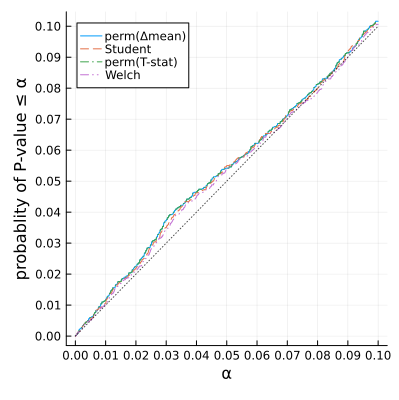

In [14]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    17.9%
  Student:        18.5%
  perm(T-stat):    6.2%
  Welch:           4.7%

  5.349811 seconds (10.82 k allocations: 3.843 MiB)


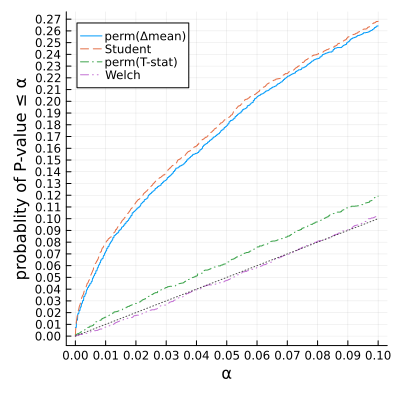

In [15]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 100
n = 25

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     0.5%
  Student:         0.5%
  perm(T-stat):    4.9%
  Welch:           5.6%

  5.474514 seconds (7.25 k allocations: 2.806 MiB)


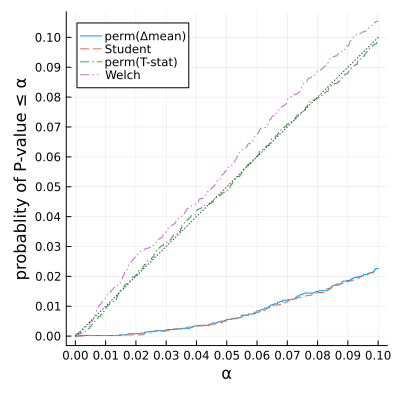

In [16]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 100, 25
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 70
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     7.8%
  Student:         7.9%
  perm(T-stat):    5.3%
  Welch:           5.0%

  7.395540 seconds (9.45 k allocations: 3.451 MiB)


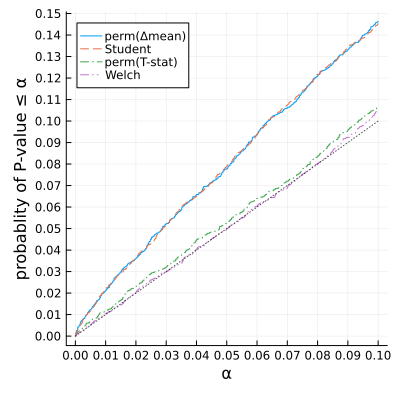

In [17]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 70, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=1.5)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 50
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     8.2%
  Student:         8.3%
  perm(T-stat):    5.0%
  Welch:           4.6%

  6.619232 seconds (9.64 k allocations: 3.479 MiB)


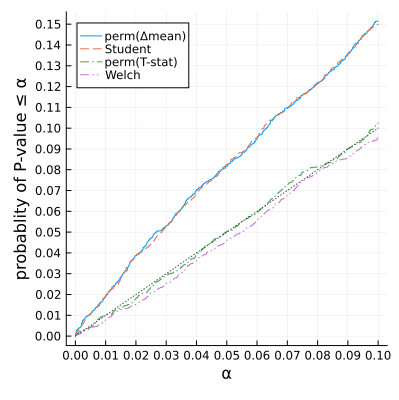

In [18]:
distx, disty = Normal(0, 1.5), Normal(0, 1)
m, n = 50, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 50
n = 50

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     5.0%
  Student:         4.7%
  perm(T-stat):    5.0%
  Welch:           4.7%

  5.087979 seconds (618.99 k allocations: 43.545 MiB, 0.21% gc time, 47.03% compilation time)


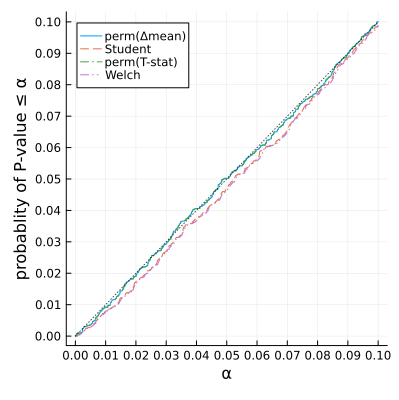

In [19]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     5.2%
  Student:         4.8%
  perm(T-stat):    5.1%
  Welch:           6.6%

  5.570778 seconds (9.22 k allocations: 3.373 MiB)


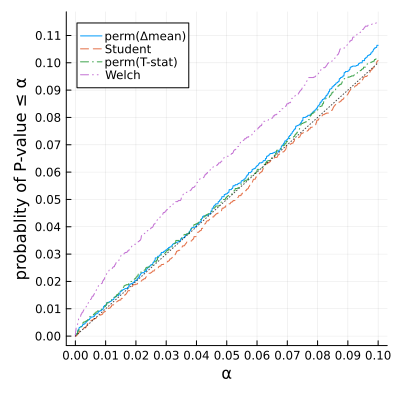

In [20]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 400

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     4.8%
  Student:         4.9%
  perm(T-stat):    4.6%
  Welch:           5.1%

 19.929062 seconds (9.37 k allocations: 3.426 MiB)


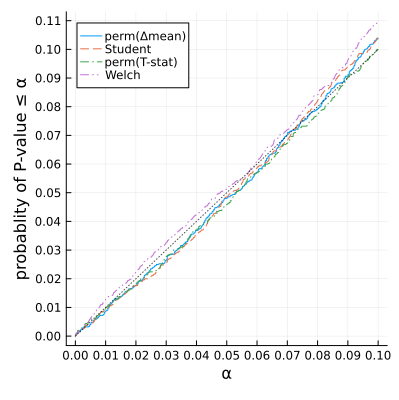

In [21]:
distx, disty = inversegammadist(1, 3), inversegammadist(1, 3)
m, n = 100, 400
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 50
n = 50

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     5.8%
  Student:         5.7%
  perm(T-stat):    5.8%
  Welch:           5.6%

  5.005674 seconds (447.30 k allocations: 32.281 MiB, 0.34% gc time, 35.24% compilation time)


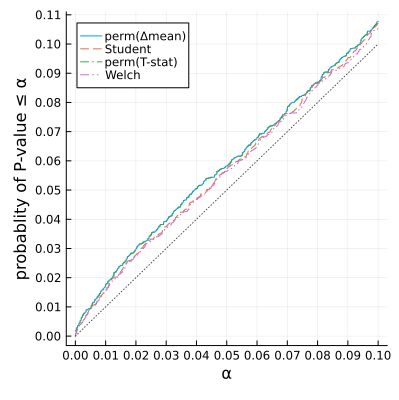

In [22]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 50, 50
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     5.5%
  Student:         5.4%
  perm(T-stat):    5.5%
  Welch:           5.4%

  8.632789 seconds (9.05 k allocations: 3.323 MiB)


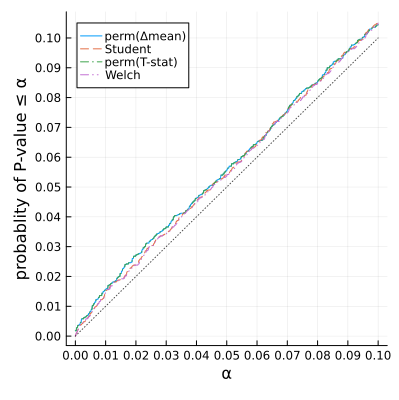

In [23]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    17.5%
  Student:        17.8%
  perm(T-stat):    7.2%
  Welch:           6.9%

  5.644790 seconds (10.91 k allocations: 3.859 MiB)


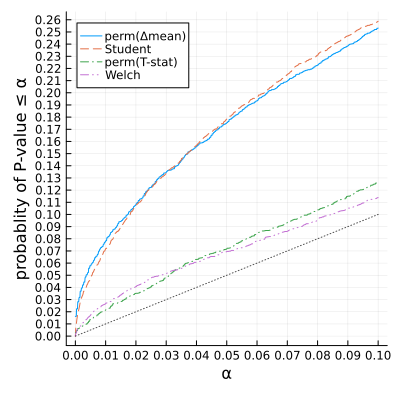

In [24]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 25, 100
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 400

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    16.7%
  Student:        16.9%
  perm(T-stat):    5.7%
  Welch:           5.4%

 21.411765 seconds (10.97 k allocations: 3.906 MiB)


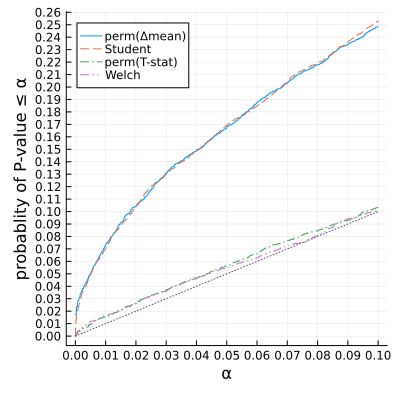

In [25]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 400
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 100
n = 25

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     0.7%
  Student:         0.8%
  perm(T-stat):    4.2%
  Welch:           4.6%

  6.017994 seconds (7.47 k allocations: 2.853 MiB)


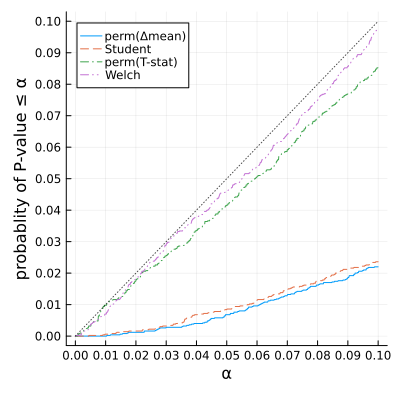

In [26]:
distx, disty = inversegammadist(2, 3), inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m, n = 100, 25
L = Nshuffles = 5000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

# 検出力

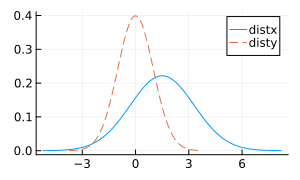

In [27]:
distx, disty = Normal(1.5, 1.8), Normal(0, 1)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)
plot!(size=(300, 180))

distx = Normal{Float64}(μ=1.5, σ=1.8)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 20
n = 10

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    69.0%
  Student:        67.8%
  perm(T-stat):   77.2%
  Welch:          80.2%

  2.165522 seconds (204.19 k allocations: 17.825 MiB, 3.39% compilation time)


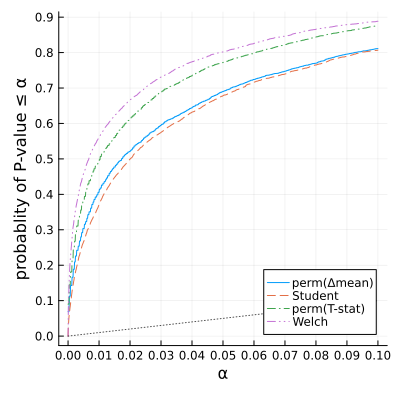

In [28]:
Random.seed!(4649373)
distx, disty = Normal(1.5, 1.8), Normal(0, 1)
m, n = 20, 10
L = Nshuffles = 5000
ytick = 0:0.1:1
legend = :bottomright
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles, ytick, legend)

distx = Normal{Float64}(μ=0.0, σ=1.8)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 20
n = 10

Probabilities of P-value ≤ 5.0%
  perm(Δmean):     2.1%
  Student:         2.0%
  perm(T-stat):    3.9%
  Welch:           4.9%

  2.090271 seconds (8.00 k allocations: 3.008 MiB)


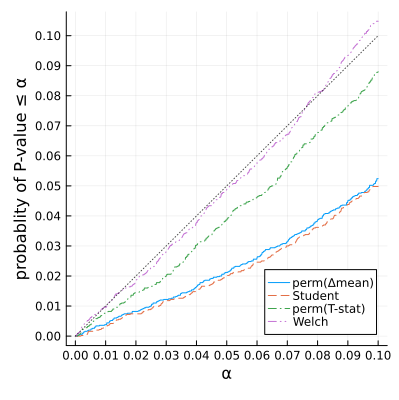

In [29]:
distx, disty = Normal(0, 1.8), Normal(0, 1)
m, n = 20, 10
L = Nshuffles = 5000
ytick = 0:0.01:1
legend = :bottomright
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles, ytick, legend)

(mean(distx), mean(disty)) = (3.5714285714285716, 2.0)
(std(distx), std(disty)) = (2.0, 1.0)


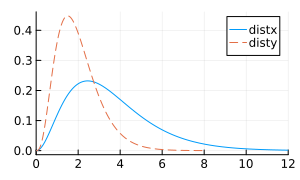

In [30]:
distx, disty = gammadist(2, 1.12), gammadist(1, 1)
@show mean(distx), mean(disty)
@show std(distx), std(disty)
plot(distx; label="distx")
plot!(disty; label="disty", ls=:dash)
plot!(size=(300, 180), xlim=(0, 12))

distx = Gamma{Float64}(α=3.1887755102040813, θ=1.12)
disty = Gamma{Float64}(α=4.0, θ=0.5)
m = 20
n = 10

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    72.4%
  Student:        66.3%
  perm(T-stat):   73.1%
  Welch:          80.1%

  2.359745 seconds (368.21 k allocations: 28.941 MiB, 0.48% gc time, 75.52% compilation time)


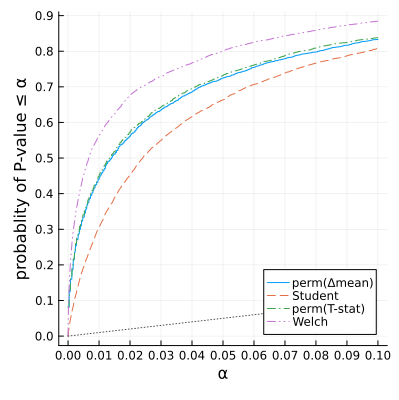

In [31]:
Random.seed!(4649373)
distx, disty = gammadist(2, 1.12), gammadist(1, 1)
m, n = 20, 10
L = Nshuffles = 5000
ytick = 0:0.1:1
legend = :bottomright
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles, ytick, legend)

(mean(distx), mean(disty)) = (2.0, 2.0)
(std(distx), std(disty)) = (2.0, 1.0)

distx = LocationScale{Float64, Continuous, Gamma{Float64}}(
μ: -1.5714285714285716
σ: 1.0
ρ: Gamma{Float64}(α=3.1887755102040813, θ=1.12)
)

disty = Gamma{Float64}(α=4.0, θ=0.5)
m = 10
n = 20

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    11.3%
  Student:        11.4%
  perm(T-stat):    7.6%
  Welch:           6.2%

  2.291208 seconds (430.56 k allocations: 31.255 MiB, 67.82% compilation time)


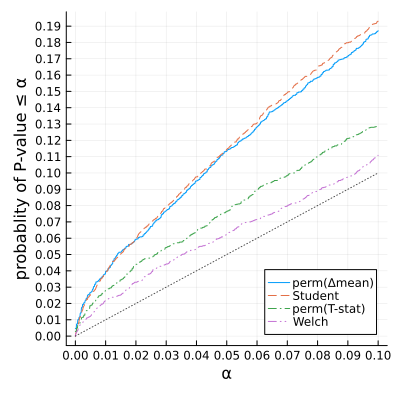

In [32]:
Random.seed!(4649373)
distx, disty = gammadist(2, 1.12), gammadist(1, 1)
distx = distx + mean(disty) - mean(distx)
@show mean(distx), mean(disty)
@show std(distx), std(disty)
println()
m, n = 10, 20
L = Nshuffles = 5000
ytick = 0:0.01:1
legend = :bottomright
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles, ytick, legend)

# ベンチマーク

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    19.0%
  Student:        19.6%
  perm(T-stat):    8.8%
  Welch:           6.4%

  0.064435 seconds (3.12 k allocations: 633.805 KiB)


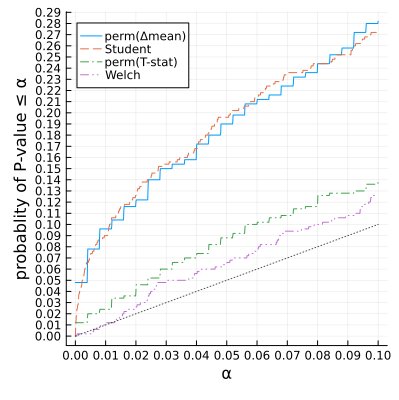

In [33]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 500
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    17.4%
  Student:        17.4%
  perm(T-stat):    7.8%
  Welch:           7.0%

  0.226956 seconds (4.04 k allocations: 996.227 KiB)


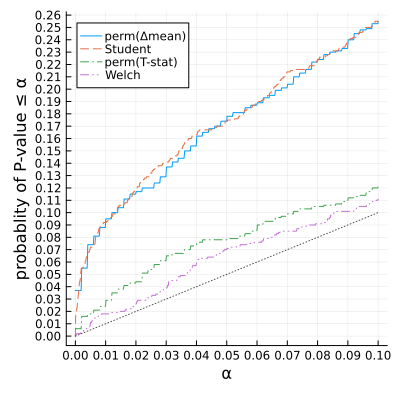

In [34]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 1000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    17.4%
  Student:        18.2%
  perm(T-stat):    6.6%
  Welch:           4.7%

  0.910636 seconds (5.71 k allocations: 1.685 MiB)


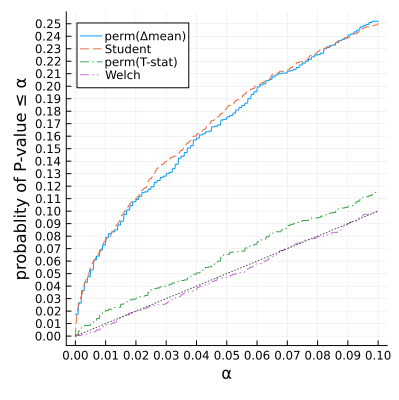

In [35]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 2000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    18.1%
  Student:        18.4%
  perm(T-stat):    7.1%
  Welch:           5.6%

  2.180164 seconds (7.38 k allocations: 2.387 MiB)


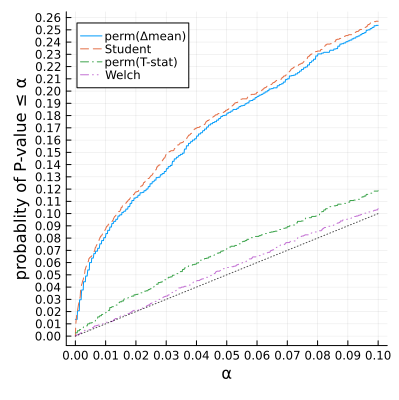

In [36]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 3000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)

distx = Normal{Float64}(μ=0.0, σ=2.0)
disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100

Probabilities of P-value ≤ 5.0%
  perm(Δmean):    17.8%
  Student:        18.8%
  perm(T-stat):    6.5%
  Welch:           4.9%

  4.055082 seconds (9.00 k allocations: 3.080 MiB)


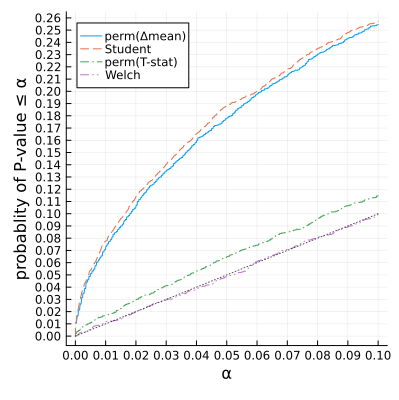

In [37]:
distx, disty = Normal(0, 2), Normal(0, 1)
m, n = 25, 100
L = Nshuffles = 4000
@time plot_sim_diff_shuffle(; distx, m, disty, n, L, Nshuffles)